# How to make kmap!

In [1]:
from SMPy.KaiserSquires import run
config_path = '/home/wslgeorgios/SMPy/SMPy/KaiserSquires/example_config.yaml'
run.run(config_path)

# Testing during Development

## Load in Shear Catalog

In [3]:
from SMPy import utils

In [2]:
path = '/home/wslgeorgios/SMPy/notebooks/forecast_lum_annular.fits'
shear_df = utils.load_shear_data_test(path, 'ra', 'dec', 'g1_Rinv', 'g2_Rinv', 'weight')
shear_df

,ra,dec,g1,g2,weight
0,199.436121,32.975130,-0.832185,-0.329239,3.289114
1,199.649709,32.975024,-0.045790,-0.618257,3.676469
2,199.382810,32.975117,0.708573,0.527764,3.639724
3,199.383113,32.974996,0.523717,0.502735,3.586006
4,199.547529,32.975129,-0.085572,-0.037222,3.682295
...,...,...,...,...,...
8762,199.344100,33.148682,-0.179205,-0.475623,3.776079
8763,199.637278,33.147841,-0.716973,-0.286508,3.688194
8764,199.638768,33.147945,-0.006985,0.281479,3.631956
8765,199.479418,33.147894,0.268532,0.154718,3.788313


## Convert DataFrame to Spacial Representation

### Compute the boundaries of the field

In [3]:
resolution = 0.141  # Resolution in arcminutes
width = 220  # Width in pixels
boundaries = utils.calculate_field_boundaries(shear_df['ra'], shear_df['dec'], resolution, width)
print(boundaries)

{'ra_min': 199.24285657428126, 'ra_max': 199.75985657428126, 'dec_min': 32.84261107631841, 'dec_max': 33.35961107631841}


### Spatial binning

In [4]:
g1map, g2map = utils.create_shear_grid(shear_df['ra'], 
                                 shear_df['dec'], 
                                 shear_df['g1'],
                                 shear_df['g2'], 
                                 shear_df['weight'],
                                 boundaries=boundaries,
                                 npix=width,
                                 )

## Kaiser-Squires Inversion

In [8]:
from SMPy.KaiserSquires import kaiser_squires
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

In [9]:
# Calculate the convergence map
convergence = kaiser_squires.ks_inversion(g1map, -g2map, width)

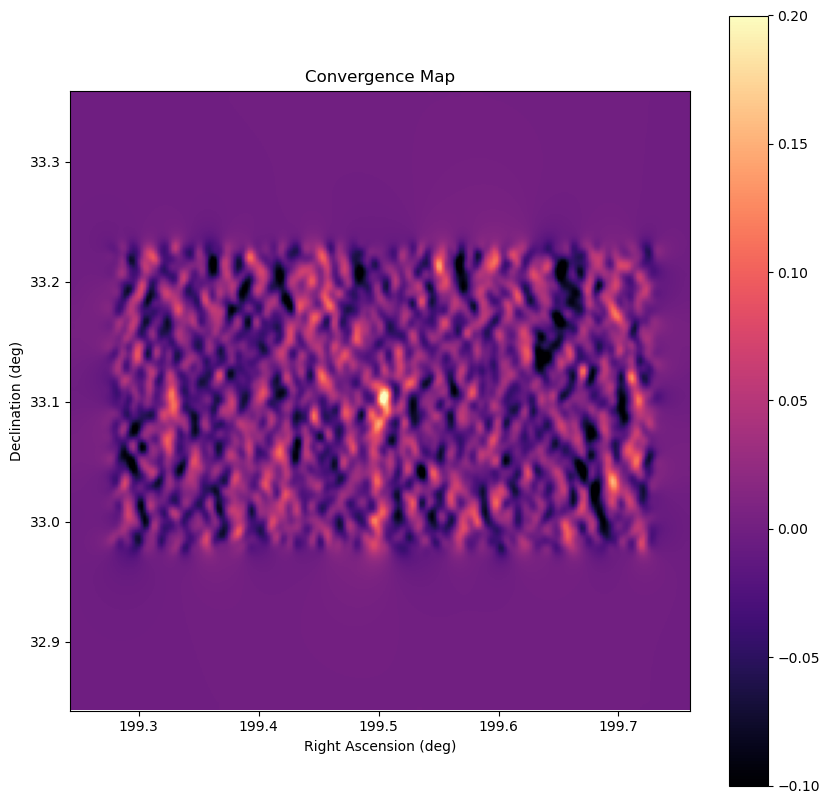

In [22]:
# Plot the convergence map
plt.figure(figsize=[10, 10])
plt.imshow(gaussian_filter(convergence, 1.5)[:, ::-1],
           cmap='magma',
           vmax=0.2,
           vmin=-0.1,
           extent=[boundaries['ra_min'], 
                   boundaries['ra_max'], 
                   boundaries['dec_min'], 
                   boundaries['dec_max']])
plt.colorbar()
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title('Convergence Map')
plt.savefig('/home/wslgeorgios/mykmap.png')

In [1]:
from astropy.io import fits
import numpy as np

# The path to your FITS file
truth_path = '/home/wslgeorgios/Abell3411_lensing_galaxies.fits'

# Open the FITS file in update mode so we can modify it
with fits.open(truth_path, mode='update') as hdul:
    # Access the table in the second HDU (HDUs are 0-indexed; HDU 1 is the second element)
    data_hdu = hdul[1].data

    # Number of rows in the existing table
    n_rows = len(data_hdu)

    # Create a new column called 'weight' with all values set to 0.3
    # The shape and type of the column need to match those of the existing table
    new_column = fits.Column(name='weight', format='D', array=np.full(n_rows, 0.3))

    # Create a new ColDefs (column definitions) object that includes the new column
    # This requires extracting the existing columns and adding the new one
    new_cols = hdul[1].columns + fits.ColDefs([new_column])

    # Create a new table HDU with the updated column definitions
    new_table_hdu = fits.BinTableHDU.from_columns(new_cols)

    # Replace the old table HDU with the new one
    hdul[1] = new_table_hdu

    # Write the changes back to the file
    hdul.flush()


In [21]:
Abell3411_path = '/home/wslgeorgios/Abell3411_lensing_galaxies.fits'
shear_df_Abell3411 = utils.load_shear_data(Abell3411_path, 'ra', 'dec', 'g1_noshear', 'g2_noshear', 'weight')
shear_df_Abell3411

,ra,dec,g1,g2,weight
0,130.517356,-17.706610,0.232587,-0.101863,0.3
1,130.462318,-17.703911,-0.057853,-0.200951,0.3
2,130.526883,-17.703061,0.062361,0.017037,0.3
3,130.501694,-17.701102,0.274872,-0.275733,0.3
4,130.443607,-17.700304,0.033691,0.181282,0.3
...,...,...,...,...,...
5757,130.481162,-17.426439,0.617210,-0.492510,0.3
5758,130.262460,-17.425831,-0.063268,-0.070131,0.3
5759,130.368863,-17.425435,0.227570,0.163474,0.3
5760,130.315193,-17.428041,-0.084487,-0.092506,0.3


In [19]:
from astropy.io import fits
import numpy as np

# The path to your FITS file
truth_path = '/home/wslgeorgios/Abell3411_lensing_galaxies.fits'

# Open the FITS file in update mode so we can modify it
with fits.open(truth_path, mode='update') as hdul:
    # Access the table in the second HDU
    table_hdu = hdul[1]

    # Access the 'g_noshear' column data
    g_noshear_data = table_hdu.data['g_noshear']

    # Extract g1_noshear and g2_noshear data
    g1_noshear_data = g_noshear_data[:, 0]
    g2_noshear_data = g_noshear_data[:, 1]

    # Create new columns for g1_noshear and g2_noshear
    g1_column = fits.Column(name='g1_noshear', format='D', array=g1_noshear_data)
    g2_column = fits.Column(name='g2_noshear', format='D', array=g2_noshear_data)

    # Create a new ColDefs (column definitions) object that includes the new columns
    new_cols = fits.ColDefs([g1_column, g2_column])

    # Append the new columns to the existing table's columns
    all_columns = fits.ColDefs(table_hdu.columns + new_cols)

    # Create a new table HDU with the updated columns
    new_table_hdu = fits.BinTableHDU.from_columns(all_columns)

    # Replace the old table HDU with the new one
    hdul[1] = new_table_hdu

    # Write the changes back to the file
    hdul.flush()
